**Load Libraries**

In [1]:
# Plotting and Data Manipulation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xlsxwriter

**Combine 2015-2022 Datasets**

In [2]:
data_directory = '../Data/'
years = range(2015, 2023)

# Initialize an empty DataFrame to store all the data
df_all = pd.DataFrame()

for year in years:
    file_path = f'{data_directory}{year}_Boston_Crimes.csv'

    # Resolve warning using dtype: "DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False."
    df = pd.read_csv(file_path, dtype={'INCIDENT_NUMBER': 'str'})

    # Add Year Column
    df['YEAR'] = year

    # Concatenate the current DataFrame with the existing data
    df_all = pd.concat([df_all, df], ignore_index=True)

df_all

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I172040657,2629,Harassment,HARASSMENT,C11,397,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,MELBOURNE ST,42.291093,-71.065945,"(42.29109287, -71.06594539)"
1,I182061268,3201,Property Lost,PROPERTY - LOST,NaN,,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,BERNARD,NaN,NaN,NaN
2,I162013546,3201,Property Lost,PROPERTY - LOST,B3,433,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813,"(42.28363434, -71.08281320)"
3,I152051083,3115,Investigate Person,INVESTIGATE PERSON,A7,20,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247,"(42.37702319, -71.03224730)"
4,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887,"(42.29360585, -71.07188650)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656899,232000091,1402,NaN,VANDALISM,A1,66,0,2022-12-31 23:30:00,2022,12,Saturday,23,NaN,CHARLES ST,42.359790,-71.070782,"(42.35979037458775, -71.07078234449541)"
656900,232000002,3831,NaN,M/V - LEAVING SCENE - PROPERTY DAMAGE,C11,,0,2022-12-31 23:37:00,2022,12,Saturday,23,NaN,COLUMBIA RD,42.319593,-71.062607,"(42.31959298334654, -71.06260699634272)"
656901,232000140,619,NaN,LARCENY ALL OTHERS,D14,778,0,2022-12-31 23:45:00,2022,12,Saturday,23,NaN,WASHINGTON ST,42.349056,-71.150498,"(42.34905600030506, -71.15049849975023)"
656902,232000315,3201,NaN,PROPERTY - LOST/ MISSING,D4,167,0,2022-12-31 23:50:00,2022,12,Saturday,23,NaN,HARRISON AVENUE,NaN,NaN,NaN


**Manually group the categories**

In [3]:
# Define the grouped_categories dictionary
grouped_categories = {
    'Violent Crimes': ['Murder', 'Killing', 'Manslaughter', 'Weapon', 'Firearm', 'Robbery', 'Assault', 'Stalking', 'Kidnapping', 'THREATS TO DO BODILY HARM'],
    'Sexual Offenses': ['Rape', 'Prostitution', 'Indecent', 'Lewdness', 'Sex Offense', 'Failure To Register As A Sex Offender'],
    'Property Crimes': ['Burglary', 'Larceny', 'Arson', 'Stolen Property', 'Vandalism', 'Graffiti', 'Property', 'Trespassing', 'Possession Of Burglarious Tools', 'Explosives - Possession or Use'],
    'Vehicle Crimes': ['Auto Theft', 'Operating under', 'Parking Violation', 'Violation of Auto Law', 'M/V', 'VAL', 'MOTOR VEHICLE', 'BREAKING AND ENTERING (B&E) MOTOR VEHICLE', 'BREAKING AND ENTERING (B&E) MOTOR VEHICLE (NO PROPERTY STOLEN)', 'RECOVERED - MV RECOVERED IN BOSTON'],
    'White-Collar Crimes': ['Forgery', 'Counterfeiting', 'Uttering', 'Confidence Games', 'Fraud', 'Embezzlement', 'Gambling', 'Extortion Or Blackmail'],
    'Substance Abuse': ['Drugs', 'Liquor', 'Alcohol', 'DRUNKENNESS'],
    'Crimes Involving Minors': ['Child Abandonment', 'Child Endangerment', 'Child Abuse', 'Contributing to Delinquency of a Minor', 'CHINS', 'Truancy'],
    'Public Order Crimes': ['Affray', 'Disorderly', 'Disturbing the Peace', 'Verbal Dispute', 'Gathering Causing Annoyance', 'Noisy Party', 'Demonstrations/Riot', 'Demonstrations / Riot', 'Dangerous Or Hazardous Condition', 'Bomb Threat', 'Violation - City Ordinance', 'Criminal Harassment', 'Criminal Harrassment', 'Evading Fare'],
    'Investigation': ['Investigate', 'INVESTIGATION'],
    'Sick-Related Crimes': ['Sick'],
    'Missing Person': ['Missing Person'],
    'Suicide or Sudden Death': ['SUDDEN DEATH', 'SUICIDE'],
    'Others': ['Other Offense', 'Aircraft Incidents', 'Animal', 'Ballistics Evidence', 'Explosives - Turned In or Found', 'Fire Report', 'Missing Person', 'Prisoner', 'Suicide', 'Sudden Death', 'Sick', 'Threats To Do Bodily Harm', 'Death Investigation', 'Investigate Person', 'Fugitive From Justice', 'Towed Motor Vehicle', 'License Premise Violation', 'Landlord - Tenant Service', 'Service To Other PD Outside Of MA.', 'Recovered - MV Recovered In Boston (Stolen Out...)', 'Search Warrant', 'Warrant Arrest', 'Harbor Incident / Violation', 'Harbor Incidents', 'Intimidating Witness', 'Protective Custody / Safekeeping', 'Safekeeping', 'Obscene Phone Calls', 'RECOVERED - MV RECOVERED IN BOSTON (STOLEN OUTSIDE BOSTON)']
}

# Create a new column 'Category' based on 'OFFENSE_DESCRIPTION' column
def categorize_name(name):
    if isinstance(name, str):
        name = name.upper()  # Convert the input name to uppercase
        for k, v in grouped_categories.items():
            if any(keyword.upper() in name for keyword in v):
                v
                return k
    return 'Others'

df_all['Category'] = df_all['OFFENSE_DESCRIPTION'].apply(categorize_name)

df_all[['OFFENSE_DESCRIPTION', 'Category']]

,OFFENSE_DESCRIPTION,Category
0,HARASSMENT,Others
1,PROPERTY - LOST,Property Crimes
2,PROPERTY - LOST,Property Crimes
3,INVESTIGATE PERSON,Investigation
4,THREATS TO DO BODILY HARM,Violent Crimes
...,...,...
656899,VANDALISM,Property Crimes
656900,M/V - LEAVING SCENE - PROPERTY DAMAGE,Property Crimes
656901,LARCENY ALL OTHERS,Property Crimes
656902,PROPERTY - LOST/ MISSING,Property Crimes


**Check for any NaN values under 'Category'**

In [4]:
df_all[df_all['Category'].isna()]

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,Category


**Display all crimes in a bar graph**

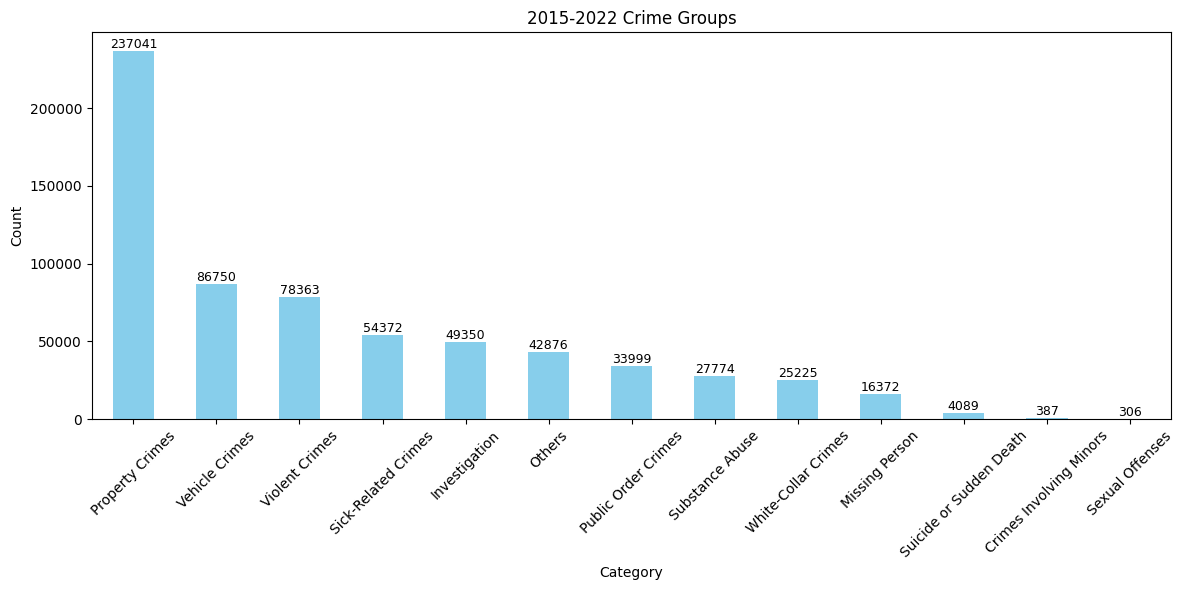

In [5]:
# Count the occurrences of each category
category_counts = df_all['Category'].value_counts()

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = category_counts.plot(kind='bar', color='skyblue')
plt.title('2015-2022 Crime Groups')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Add total count labels on top of each bar
for i, v in enumerate(category_counts):
    ax.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Show the plot
plt.show()

Save for processing in Tableau and Power BI

In [6]:
# Replace 'your_path/df_all.csv' with the desired file path
file_path = f'{data_directory}2015_to_2022_Boston_Crimes.xlsx'

# Save the DataFrame to an Excel file with a custom sheet name
df_all.to_excel(file_path, sheet_name='Boston Crimes', engine="xlsxwriter")